In [50]:
import pandas as pd
import numpy as np

## Preprocessamento dos dados

In [6]:
def load(file_path):
  df = pd.read_csv(file_path)
  m, s = df['tow'].mean(), df['tow'].std()
  df['date'] = pd.to_datetime(df['date'])
  df['actual_offblock_time'] = pd.to_datetime(df['actual_offblock_time'])
  df['arrival_time'] = pd.to_datetime(df['arrival_time'])
  df['offblock_hour'] = df['actual_offblock_time'].dt.round('h').dt.hour
  df['offblock_day_of_week'] = df['actual_offblock_time'].dt.dayofweek
  df['offblock_month'] = df['actual_offblock_time'].dt.month
  df = df.drop(columns=['flight_id','name_adep', 'callsign', 'actual_offblock_time', 'arrival_time', 'date'])
  df['tow'] = (df['tow']-m)/s
  return df, m, s # Roubando aqui na média e desvio padrão do dataset inteiro :p

df, mean, std = load('challenge_set.csv')
df.head()

,adep,country_code_adep,ades,name_ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow,offblock_hour,offblock_day_of_week,offblock_month
0,EGLL,GB,EICK,Cork,IE,A320,M,a73f82288988b79be490c6322f4c32ed,61,18,321,-0.464485,14,5,1
1,LEBL,ES,KMIA,Miami,US,B772,H,5543e4dc327359ffaf5b9c0e6faaf0e1,570,13,4193,1.989801,10,5,1
2,ESSA,SE,KORD,Chicago O'Hare,US,A333,H,8be5c854fd664bcb97fb543339f74770,554,15,3770,2.834012,10,5,1
3,LSZH,CH,KPHL,Philadelphia,US,B788,H,5543e4dc327359ffaf5b9c0e6faaf0e1,497,11,3607,1.467256,11,5,1
4,EIDW,IE,EGLL,London Heathrow,GB,A21N,M,a73f82288988b79be490c6322f4c32ed,55,14,305,-0.172087,13,5,1


## Modelo (com pre-processamento auto)

In [11]:
null_value_stats = df.isnull().sum(axis=0)
print(null_value_stats)

adep                    0
country_code_adep       0
ades                    0
name_ades               0
country_code_ades       0
aircraft_type           0
wtc                     0
airline                 0
flight_duration         0
taxiout_time            0
flown_distance          0
tow                     0
offblock_hour           0
offblock_day_of_week    0
offblock_month          0
dtype: int64


In [16]:
X = df.drop('tow', axis=1)
y = df.tow

In [17]:
print(X.dtypes)

adep                    object
country_code_adep       object
ades                    object
name_ades               object
country_code_ades       object
aircraft_type           object
wtc                     object
airline                 object
flight_duration          int64
taxiout_time             int64
flown_distance           int64
offblock_hour            int32
offblock_day_of_week     int32
offblock_month           int32
dtype: object


In [ ]:
categorical_features_indices = [

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42)

In [20]:
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import r2_score, mean_squared_error

In [22]:
model = CatBoostRegressor(
    objective='RMSE',
    random_seed=42,
    logging_level='Silent'
)

In [23]:
cat_names = ['adep', 'country_code_adep', 'ades', 'name_ades', 'country_code_ades',
             'aircraft_type', 'wtc', 'airline', 'offblock_hour', 'offblock_day_of_week', 'offblock_month']

In [29]:
model.fit(
    X_train, y_train,
    cat_features=cat_names,
    eval_set=(X_val, y_val),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [58]:
params = {
    'objective': 'RMSE',
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': metrics.RMSE(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False,
}
train_pool = Pool(X_train, y_train, cat_features=cat_names)
val_pool = Pool(X_val, y_val, cat_features=cat_names)

In [112]:
%%time
from sklearn.metrics import root_mean_squared_error

model = CatBoostRegressor(**params)
model.fit(train_pool, eval_set=val_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostRegressor(**best_model_params)
best_model.fit(train_pool, eval_set=val_pool)

print('Simple model validation MSE: {:.4}'.format(
    root_mean_squared_error(y_val, model.predict(X_val))
))
print('')

print('Best model validation MSE: {:.4}'.format(
    root_mean_squared_error(y_val, best_model.predict(X_val))
))

Simple model validation MSE: 0.07369

Best model validation MSE: 0.07381
CPU times: user 28.1 s, sys: 2.46 s, total: 30.5 s
Wall time: 19.6 s


## Training on GPU

In [62]:
params = {
    'objective': 'RMSE',
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': metrics.RMSE(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False,
    'task_type': 'GPU',
}
train_pool = Pool(X_train, y_train, cat_features=cat_names)
val_pool = Pool(X_val, y_val, cat_features=cat_names)

In [63]:
%%time
from sklearn.metrics import mean_squared_error

model = CatBoostRegressor(**params)
model.fit(train_pool, eval_set=val_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostRegressor(**best_model_params)
best_model.fit(train_pool, eval_set=val_pool)

print('Simple model validation MSE: {:.4}'.format(
    root_mean_squared_error(y_val, model.predict(X_val))
))
print('')

print('Best model validation MSE: {:.4}'.format(
    root_mean_squared_error(y_val, best_model.predict(X_val))
))

Simple model validation MSE: 0.005413

Best model validation MSE: 0.005411
CPU times: user 29 s, sys: 2.26 s, total: 31.2 s
Wall time: 19.9 s


## Features Importances

In [43]:
model = CatBoostRegressor(**params).fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

wtc: 66.614928652863
aircraft_type: 13.755218568342919
airline: 6.733638730285759
flight_duration: 4.712739729990969
flown_distance: 4.572024187483981
country_code_ades: 0.9367501487493993
taxiout_time: 0.9222817534439907
country_code_adep: 0.678400556634356
ades: 0.5288999522061736
offblock_hour: 0.42518023304026265
offblock_month: 0.09052470234923729
offblock_day_of_week: 0.029412784609957485
name_ades: 0.0
adep: 0.0


## Hyperparameter Tunning

In [47]:
!pip install hyperopt

In [106]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostRegressor(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=1000,
        eval_metric=metrics.RMSE(),
        random_seed=42,
        verbose=False,
        objective=metrics.RMSE(),
        task_type='GPU', # training on GPU
        use_best_model=True,
    )

    cv_data = cv(
        Pool(X, y, cat_features=cat_names),
        model.get_params(),
        logging_level='Silent',
    )
    best_rmse = np.max(cv_data['test-RMSE-mean'])

    return best_rmse

In [105]:
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 4, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 1.0),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(123)
)

print(best)

 10%|█         | 5/50 [00:29<04:23,  5.85s/trial, best loss: 0.3175062385860914]

learning rate is greater than 1. You probably need to decrease learning rate.

learning rate is greater than 1. You probably need to decrease learning rate.

learning rate is greater than 1. You probably need to decrease learning rate.



 14%|█▍        | 7/50 [00:38<03:53,  5.43s/trial, best loss: 0.3175062385860914]

learning rate is greater than 1. You probably need to decrease learning rate.

learning rate is greater than 1. You probably need to decrease learning rate.

learning rate is greater than 1. You probably need to decrease learning rate.



 16%|█▌        | 8/50 [00:44<03:52,  5.54s/trial, best loss: 0.3175062385860914]

learning rate is greater than 1. You probably need to decrease learning rate.

learning rate is greater than 1. You probably need to decrease learning rate.

learning rate is greater than 1. You probably need to decrease learning rate.



 18%|█▊        | 9/50 [00:48<03:27,  5.06s/trial, best loss: 0.3175062385860914]

learning rate is greater than 1. You probably need to decrease learning rate.

learning rate is greater than 1. You probably need to decrease learning rate.

learning rate is greater than 1. You probably need to decrease learning rate.



 22%|█▉       | 11/50 [00:59<03:26,  5.30s/trial, best loss: 0.3175062385860914]

learning rate is greater than 1. You probably need to decrease learning rate.

learning rate is greater than 1. You probably need to decrease learning rate.

learning rate is greater than 1. You probably need to decrease learning rate.



 22%|█▉       | 11/50 [01:02<03:42,  5.70s/trial, best loss: 0.3175062385860914]


KeyboardInterrupt: 

In [107]:
model = CatBoostRegressor(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=3000,
    eval_metric=metrics.RMSE(),
    random_seed=42,
    verbose=False,
    objective=metrics.RMSE(),
    task_type='GPU',
    use_best_model=True,
)
cv_data = cv(Pool(X, y, cat_features=cat_names), model.get_params(), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
bestTest = 0.0719344877
bestIteration = 2995
Training on fold [1/3]
bestTest = 0.0709938605
bestIteration = 2925
Training on fold [2/3]
bestTest = 0.0713973583
bestIteration = 2986


In [109]:
print('Precise validation RMSE score: {}'.format(np.min(cv_data['test-RMSE-mean'])))

Precise validation RMSE score: 0.07144757915986595


In [110]:
model.fit(train_pool, eval_set=val_pool)

(-0.0005016623577173212, 0.07198964814909342)

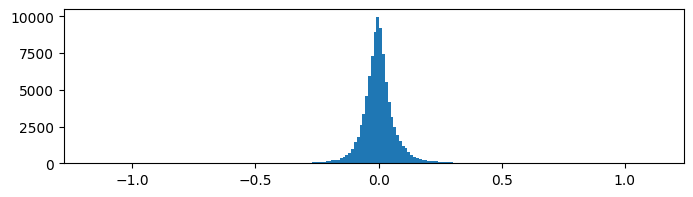

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
preds_val = model.predict(X_val)
diff_val = preds_val - y_val
plt.hist(diff_val, bins=200)
diff_val.mean(), diff_val.std()

In [113]:
print('Model validation RMSE: {:.4}'.format(
    root_mean_squared_error(y_val * std + mean, preds_val * std + mean)
))

Model validation RMSE: 3.834e+03


## Submissão

In [96]:
df_test, _, _ = load('submission_set.csv')
df_test.head()

,adep,country_code_adep,ades,name_ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow,offblock_hour,offblock_day_of_week,offblock_month
0,LTFJ,TR,LFLL,Lyon,FR,B738,M,6351ec1b849adacc0cbb3b1313d8d39b,170,15,1122,NaN,10,5,1
1,EBBR,BE,KJFK,New York JFK,US,A333,H,bdeeef3a675587d530de70a25d7118d2,470,15,3205,NaN,10,5,1
2,KMIA,US,EGLL,London Heathrow,GB,B77W,H,5543e4dc327359ffaf5b9c0e6faaf0e1,473,10,3965,NaN,2,5,1
3,EGCN,GB,LEAL,Alicante,ES,B38M,M,3922524069809ac4326134429751e26f,156,10,986,NaN,8,5,1
4,EIDW,IE,LFLL,Lyon,FR,A320,M,a73f82288988b79be490c6322f4c32ed,105,15,686,NaN,11,5,1


In [97]:
X_test = df_test.drop('tow', axis=1)

In [100]:
y_pred = model.predict(X_test)
y_test = y_pred * std + mean

In [101]:
y_test

array([ 69238.70389826, 208278.80918999, 213498.71312059, ...,
        78344.36335698,  58749.63599476,  63962.04185803])

In [102]:
dft0 = pd.read_csv('submission_set.csv')
dft0['tow'] = y_test
dft0[['flight_id', 'tow']].to_csv('catboost.csv', index=False)

In [103]:
!head catboost.csv

flight_id,tow
248753821,69238.70389825726
248753822,208278.80918999232
248754498,213498.71312058743
248757623,64001.00893104102
248763603,64199.972194401205
248755068,58672.80695669654
248754229,57280.6246124405
248754894,58685.62020256307
248754751,56437.642355155745


In [11]:
# !mc cp ./mlp.csv dc24/submissions/team_tiny_rainbow_v2_7ec66710-1eb8-478e-8976-584c090b6373.csv